# Experiment 1.2: MLP Autoencoder with 2D Bottleneck

This is an experiment to squash higher-dimensional data into a lower-dimensional embedding space. We'll start with color: RGB values (3 dimensions) ranging from $0..1$.

We want to see if this compression forces the model to learn a meaningful representation of the color data. Specifically, since our input data primarily varies by hue (we'll use bright, saturated colors), we hypothesize that the 2D bottleneck will naturally arrange these colors into a structure resembling the familiar color wheel. This is a basic test of whether we can induce desired structures in latent space simply through architectural constraints.

## Training Data Setup

We'll use the `ColorCube` tools developed previously. For this experiment, we want data that emphasizes the hue dimension. We'll generate colors with high saturation (S=1) and high value (V=0.9 and 1.0) across a range of hues. We'll also hold out a slice of hues (between teal and blue) to see if the model leaves a corresponding gap in its learned representation, which would indicate it's not just memorizing but actually structuring the space based on the input distribution.

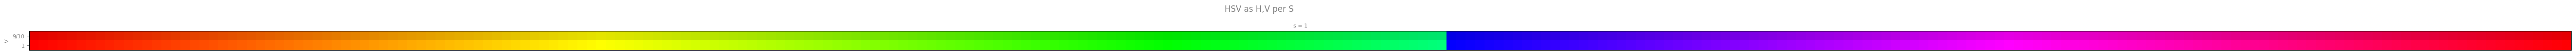

In [ ]:
import numpy as np
from ex_color.data.color import hues
from ex_color.data.color_cube import ColorCube
from ex_color.data.cyclic import arange_cyclic, isbetween_cyclic
from ex_color.vis import plot_colors

all_hues = arange_cyclic(step_size=1 / 360)

cube = ColorCube.from_hsv(
    h=all_hues[~isbetween_cyclic(all_hues, hues.teal, hues.blue)],
    # h=all_hues,
    s=np.array([1]),
    v=np.array([0.9, 1]),
)
plot_colors(cube.permute('svh'))

## Model: Simple MLP Autoencoder

The model itself is straightforward: an encoder maps the 3D RGB input down to the 2D bottleneck, and a decoder maps it back up to 3D.

We also include an option to normalize the bottleneck vectors to unit length. This is inspired by some observations in language models and might encourage the points to distribute nicely on the surface of a circle (or hypersphere in higher dimensions). Let's try it with normalization enabled.

### Model Definition and Training

Now, let's define the `ColorMLP` class and a simple training function. We'll use Mean Squared Error (MSE) loss, as is typical for autoencoders reconstructing continuous values.

During training, we'll periodically capture the state of the bottleneck layer ("latents") to visualize how the representation evolves.

In [ ]:
import torch
import torch.nn as nn
import numpy as np


class ColorMLP(nn.Module):
    def __init__(self, normalize_bottleneck=False):
        super().__init__()
        # RGB input (3D) → hidden layer → 2D bottleneck → hidden layer → RGB output
        self.encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # Our critical 2D bottleneck!
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.Sigmoid(),  # Keep RGB values in [0,1]
        )

        self.normalize = normalize_bottleneck

    def forward(self, x):
        # Get our bottleneck representation
        bottleneck = self.encoder(x)

        # Optionally normalize to unit vectors (like nGPT)
        if self.normalize:
            norm = torch.norm(bottleneck, dim=1, keepdim=True)
            bottleneck = bottleneck / (norm + 1e-8)  # Avoid division by zero

        # Decode back to RGB
        output = self.decoder(bottleneck)
        return output, bottleneck


def train_color_model(model, data: torch.Tensor, epochs=500):
    from torch import optim
    from tqdm import tqdm

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Store bottleneck values for visualization
    bottleneck_history = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            pbar.update(1)
            optimizer.zero_grad()

            # Forward pass
            outputs, _latents = model(data)
            loss = criterion(outputs, data)  # Autoencoder loss

            # Backward pass
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            if epoch % 50 == 0:
                # Save named colors' bottleneck representation
                with torch.no_grad():
                    _, latents = model(data)
                    bottleneck_history.append(latents.clone())

    return bottleneck_history


model = ColorMLP(normalize_bottleneck=True)
train_data = torch.tensor(cube.rgb_grid.reshape(-1, 3), dtype=torch.float32)
history = train_color_model(model, train_data, epochs=500)

100%|██████████| 500/500 [00:01<00:00, 441.27it/s, loss=0.0162]


Let's do a quick sanity check on the shapes and values of the final bottleneck representation and the input data.

In [3]:
print(history[-1][:3])
print(train_data[:3])

tensor([[ 0.7351, -0.6779],
        [ 0.7187, -0.6953],
        [ 0.7475, -0.6643]])
tensor([[0.9000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.9000, 0.0150, 0.0000]])


## Visualizing the Bottleneck Representation

So, did forcing the bright, saturated RGB values through the 2D bottleneck cause the model to rediscover the color wheel?

Let's create a scatter plot of the final 2D bottleneck vectors, coloring each point by its original RGB value. If our hypothesis holds, we should see a circular arrangement of colors, ordered according to the hue spectrum.

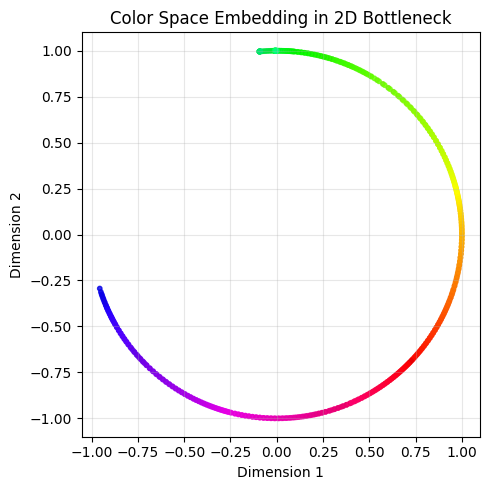

Bottleneck shape: (538, 2)
Range - X: [-0.9559, 1.0000]
Range - Y: [-1.0000, 1.0000]


In [4]:
import matplotlib.pyplot as plt

# Get the final bottleneck representations
final_bottleneck = history[-1]

# Convert tensors to numpy arrays for plotting
bottleneck_np = final_bottleneck.detach().numpy()
colors_np = train_data.numpy()

# Create a scatter plot with points colored by their RGB values
plt.figure(figsize=(5, 5))
plt.scatter(bottleneck_np[:, 0], bottleneck_np[:, 1], c=colors_np, s=10, alpha=0.8)

plt.title('Color Space Embedding in 2D Bottleneck')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Let's also analyze the shape of the distribution
print(f'Bottleneck shape: {bottleneck_np.shape}')
print(f'Range - X: [{bottleneck_np[:, 0].min():.4f}, {bottleneck_np[:, 0].max():.4f}]')
print(f'Range - Y: [{bottleneck_np[:, 1].min():.4f}, {bottleneck_np[:, 1].max():.4f}]')

Indeed, the model clearly learned a circular representation very similar to the standard color wheel! The colors are arranged in the correct order by hue. Notice the gap between teal and blue – this corresponds to the hue range we excluded from the training data. This is some evidence that the model is learning a structured representation of hue.

The orientation of the wheel varies with each training run (due to random initialization), but the relative arrangement of colors and the gap are consistent. The normalization we applied likely helped achieve this clean circular shape.

**Next steps:**
This worked well for hue, but our data only included fully saturated, bright colors. What happens if we introduce variations in saturation and value? A 2D bottleneck is likely insufficient. In the next experiment ([Experiment 1.3](ex-1.3-color-mlp-curriculum.ipynb)), we'll try:
1. Using a 3D bottleneck.
2. Introducing curriculum learning: start by training on hues (like here), then gradually introduce colors with varying saturation and value.

Hopefully, we would see the positions of the hues held constant, with similar (new) colors placed nearby.